In [1]:
import cv2, numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Load Parameters

In [2]:
from utils import read_json

params = read_json('parameters.json')

RESIZE_X = params['resize']['x']
RESIZE_Y = params['resize']['y']
ITEM_FOLDER = params['item_folder']

## Input Data
* Image of the bin
* List of items in the bin

In [ ]:
bin_stamp = '170405145336'
contents = ["Colgate_Toothbrush_4PK","Epsom_Salts","Duct_Tape",
            "Bath_Sponge","Crayons","Burts_Bees_Baby_Wipes"]

In [3]:
bin_stamp = '170405145538'
contents = ["glue_sticks","tissue_box","laugh_out_loud_jokes",
            "toilet_brush","expo_eraser","table_cloth"]

In [4]:
contents = [s.lower() for s in contents]

## Phase 1: Recognition by SIFT Features
### Compute Features in Bin

1067 features detected in bin


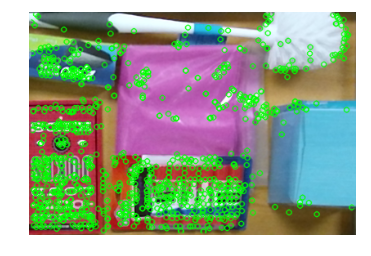

In [5]:
from utils import imread_rgb, compute_sift, draw_keypoints

filename_bin = 'bin/' + bin_stamp + '.png'
image_bin = imread_rgb(filename_bin)
(kp_bin, des_bin) = compute_sift(image_bin)
print('%d features detected in bin' % len(kp_bin))
draw_keypoints(image_bin,kp_bin)

### Match Bin and Items Features

In [6]:
from utils import read_features_from_file, read_bbox_from_file, unpack_keypoint, calc_matches

items = list(contents)

Item: "Training_items/glue_sticks/glue_sticks_top_01_sift.npy" Good features: 5
Item: "Training_items/tissue_box/tissue_box_top_01_sift.npy" Good features: 3
Item: "Training_items/laugh_out_loud_jokes/laugh_out_loud_jokes_top_01_sift.npy" Good features: 12
Item: "Training_items/toilet_brush/toilet_brush_top_01_sift.npy" Good features: 2
Item: "Training_items/expo_eraser/expo_eraser_top_01_sift.npy" Good features: 26
Item: "Training_items/table_cloth/table_cloth_top_01_sift.npy" Good features: 3


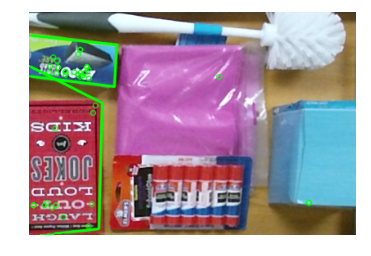

In [7]:
item_d = {}
recognised_items = []
image_disp = image_bin.copy()
mask_items = np.zeros(image_bin.shape[0:2]).astype('uint8')
for item in items:
    prefix = ITEM_FOLDER + '/' + item + '/' + item
    filename = prefix + '_top_01_sift.npy'
    kp, des = read_features_from_file(filename)
    kp, des = unpack_keypoint(kp, des)
    des = des.astype('float32')
    good = calc_matches(des, des_bin)
    item_d[item] = {'file': filename, 'kp': kp, 'des': des, 'good': good}
    
    filename = prefix + '_bottom_01_sift.npy'
    kp, des = read_features_from_file(filename)
    kp, des = unpack_keypoint(kp, des)
    des = des.astype('float32')
    good = calc_matches(des, des_bin)
    if len(good) > len(item_d[item]['good']):
        item_d[item] = {'file': filename, 'kp': kp, 'des': des, 'good': good}

    print('Item: "%s" Good features: %d' % (item_d[item]['file'], 
                                          len(item_d[item]['good'])))
    MIN_MATCH_COUNT=10
    kp = item_d[item]['kp']
    good = item_d[item]['good']
    if len(good) > MIN_MATCH_COUNT:
        dst_pts = [ kp_bin[m.trainIdx] for m in good ]
        image_disp = cv2.drawKeypoints(image_disp,dst_pts,color=(0,255,0))
        recognised_items.append(item)
        src_pts = np.float32([ kp[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp_bin[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        x, y, w, h = read_bbox_from_file(item_d[item]['file'][:-9] + '_bbox.json')
        pts = np.float32([ [x,y],[x,y+h-1],[x+w-1,y+h-1],[x+w-1,y] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)
        cv2.polylines(image_disp,[np.int32(dst)],True,(0,255,0),2, cv2.CV_AA)
        cv2.fillConvexPoly(mask_items,np.int32(dst),(255,))

plt.imshow(image_disp), plt.axis('off');

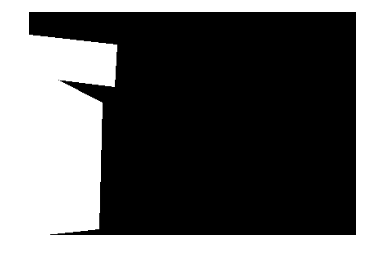

In [8]:
plt.imshow(mask_items,cmap='gray'), plt.axis('off');

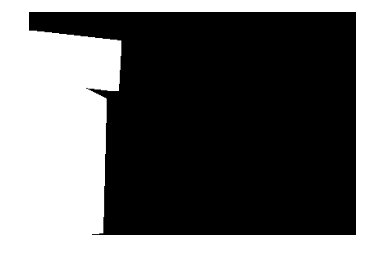

In [9]:
kernel = np.ones((3,3),np.uint8)
mask_items = cv2.dilate(mask_items,kernel,iterations = 5)
plt.imshow(mask_items,cmap='gray'), plt.axis('off');

## Phase 2: filter by depth

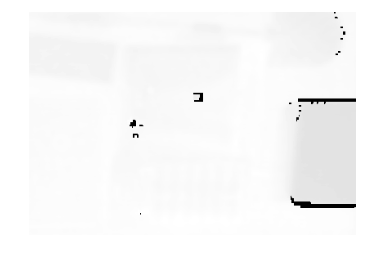

In [10]:
from utils import imread_gray
filename_bin = 'bin/' + bin_stamp + '.pgm'
image_depth = imread_gray(filename_bin)
#image_depth = cv2.bitwise_and(image_depth,image_depth,mask=255-mask_bin)
plt.imshow(image_depth,cmap='gray'); plt.axis('off');

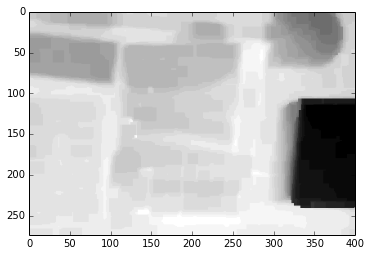

In [11]:
kernel = np.ones((3,3),'uint8')
iterations = 0
while sum(sum(image_depth==0)) > 0:
    image_depth = cv2.dilate(image_depth,kernel,borderType=cv2.BORDER_REPLICATE)
    iterations += 1
extra = 2
image_depth = cv2.dilate(image_depth,kernel,iterations=extra)
image_depth = cv2.erode(image_depth,kernel,iterations=iterations+extra)
plt.imshow(image_depth,cmap='gray');

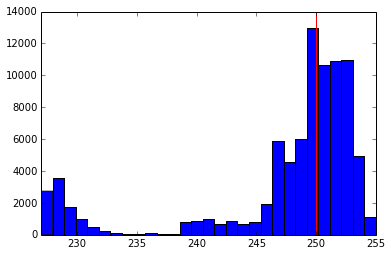

In [30]:
image_depth = cv2.bitwise_and(image_depth,image_depth,mask=255-mask_items)
pix_depth = image_depth.flatten()
pix_depth = pix_depth[pix_depth>0]
dmin, dmax = (np.min(pix_depth),np.max(pix_depth))
h,b = np.histogram(pix_depth,bins=dmax-dmin)
sh = np.cumsum(h)
b_high = [b_val for b_val,sh_val in zip(b,sh) if sh_val>sh[-1]/2]
dcut = int(b_high[0])
plt.hist(pix_depth,bins=dmax-dmin+1);
hmax = np.around(max(h)+1000,-3)
plt.plot([dcut,dcut],[0,hmax],'r-')
plt.axis([dmin,dmax,0,hmax]);

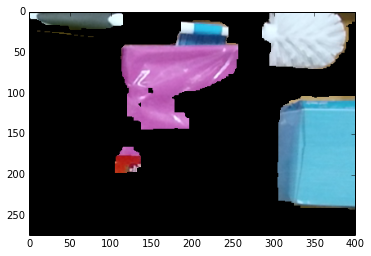

In [31]:
upper_bin = cv2.inRange(image_depth,int(dmin),dcut-1)
plt.imshow(cv2.bitwise_and(image_bin,image_bin,mask=upper_bin));

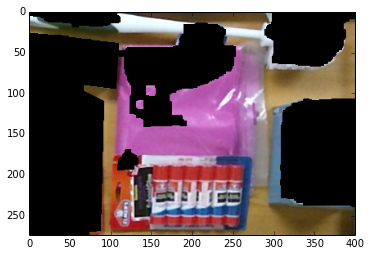

In [32]:
lower_bin = cv2.inRange(image_depth,dcut,int(dmax))
kernel = np.ones((3,3),np.uint8)
lower_bin = cv2.dilate(lower_bin,kernel,iterations = 3)
plt.imshow(cv2.bitwise_and(image_bin,image_bin,mask=lower_bin));

## Cluster colors in upper bin

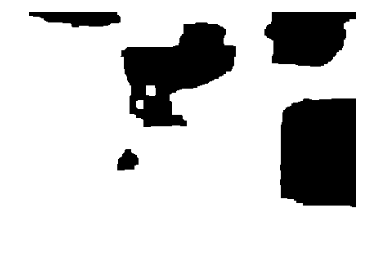

In [33]:
mask_bin = cv2.bitwise_or(mask_items,lower_bin)
plt.imshow(mask_bin,cmap='gray'), plt.axis('off');

## Cluster colors in lower bin

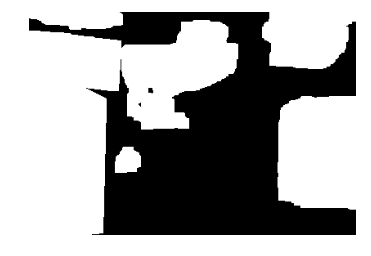

In [53]:
mask_bin = cv2.bitwise_or(mask_items,upper_bin)
plt.imshow(mask_bin,cmap='gray'), plt.axis('off');

## Phase 3: Segmentation and Recognition by Color

In [54]:
%%time
from sklearn.cluster import KMeans, MiniBatchKMeans

n_cc = 20
image_RGBA = np.dstack((image_bin, 255-mask_bin))
pixels = image_RGBA.reshape((image_RGBA.shape[0] * image_RGBA.shape[1], 4))
filtered_pixels = np.array(filter(lambda x:x[3]==255,pixels))
n, _ = filtered_pixels.shape
pixels_LAB = cv2.cvtColor(filtered_pixels[:,0:3].reshape(1,n,3),cv2.COLOR_RGB2LAB)
pixels_LAB = pixels_LAB.reshape(n,3)
#clt = MiniBatchKMeans(n_clusters = n_cc)
clt = KMeans(n_clusters = n_cc)
clt.fit(pixels_LAB)

CPU times: user 3.7 s, sys: 180 ms, total: 3.88 s
Wall time: 3.89 s


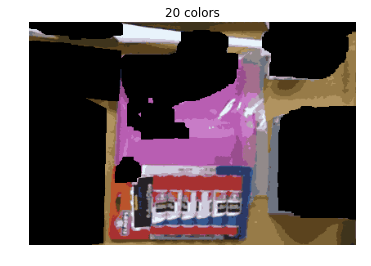

In [55]:
image = cv2.cvtColor(image_bin, cv2.COLOR_RGB2LAB)
(h_bin, w_bin) = image.shape[:2]
pixels = image.reshape((image.shape[0] * image.shape[1], 3))
labels = clt.predict(pixels)
quant = clt.cluster_centers_.astype("uint8")[labels]
quant = quant.reshape((h_bin, w_bin, 3))
quant = cv2.cvtColor(quant, cv2.COLOR_LAB2RGB)
#plt.subplot(121),plt.imshow(cv2.bitwise_and(image_bin,image_bin,mask=255-mask_bin)),plt.title('Original'),plt.axis('off');
#plt.subplot(122),plt.imshow(cv2.bitwise_and(quant,quant,mask=255-mask_bin)),plt.title('%d colors' % n_cc),plt.axis('off');
plt.imshow(cv2.bitwise_and(quant,quant,mask=255-mask_bin)),plt.title('%d colors' % n_cc),plt.axis('off');
bin_cc = clt.cluster_centers_

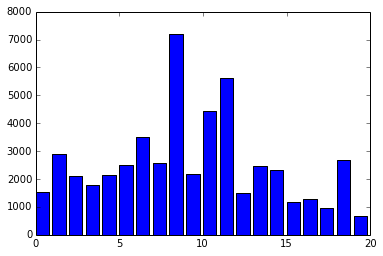

In [56]:
bin_hist, _ = np.histogram(clt.predict(pixels_LAB),bins=range(n_cc+1))
plt.bar(range(n_cc), bin_hist);

In [57]:
sort_index = np.argsort(bin_hist)[::-1]
sort_index

array([ 8, 11, 10,  6,  1, 18,  7,  5, 13, 14,  9,  4,  2,  3,  0, 12, 16,
       15, 17, 19])

In [58]:
recognised_items

['laugh_out_loud_jokes', 'expo_eraser']

In [59]:
items = [s for s in contents if s not in recognised_items]
items

['glue_sticks', 'tissue_box', 'toilet_brush', 'table_cloth']

### While not sort_index is empty

In [60]:
positions = []
weights = []
while len(sort_index)>0:
    obj_label = sort_index[0]
    d_other = [np.linalg.norm(bin_cc[obj_label,1:]-bin_cc[other,1:]) for other in sort_index]
    obj_labels = [sort_index[idx] for idx,val in enumerate(d_other) if val<20]
    obj_hist = np.array([bin_hist[obj_l] for obj_l in obj_labels],dtype='float32')
    obj_hist = obj_hist / np.sum(obj_hist)
    sort_index = np.array([x for x in sort_index if x not in obj_labels])
    mask = np.zeros((h_bin, w_bin)).astype('uint8')
    for val_label in obj_labels:
        mask = cv2.bitwise_or( mask, ((labels==val_label).astype('uint8') * 255).reshape((h_bin, w_bin)) )
    mask = cv2.bitwise_and( mask, 255-mask_bin)
    kernel = np.ones((3,3),np.uint8)
    mask = cv2.erode(mask,kernel,iterations = 3)
    mask = cv2.dilate(mask,kernel,iterations = 3)
    #cnt, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnt, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    cnt = sorted(cnt, key=lambda x:cv2.contourArea(x), reverse=True)
    best_cnt = [c for c in cnt if cv2.contourArea(c)>500]
    positions.append(best_cnt)

    best_item = []
    views = ['top_01','top-side_01','top-side_02','bottom_01','bottom-side_01','bottom-side_02']
    for item in items:
        for view in views:
            try:
                filename = ITEM_FOLDER + '/' + item + '/' + item + '_' + view + '_dc.json'
                dc = read_json(filename)
                hist = dc['hist']
                obj_cc = dc['cluster_centers']
                sum_h = 0
                for i in range(5):
                    d_bin_obj = [np.linalg.norm(obj_cc[i]-bin_cc[obj_l,:]) for obj_l in obj_labels]
                    index_min = np.argmin(d_bin_obj)
                    if d_bin_obj[index_min] < 25:
                        sum_h += hist[i] * obj_hist[index_min]
                        # hist[i] is the number of pixels in the image -> count only in rectangle?
                #if sum_h > 0.05:
                if sum_h > 0.1:
                    best_item.append((sum_h,item,view))
            except IOError:
                pass
    best_item_one = []
    for it in items:
        try:
            w = max([bi[0] for bi in best_item if bi[1]==it])
            best_item_one.append((w,it))
        except ValueError:
            pass
    weights.append(best_item_one)


In [61]:
weights

[[(0.43939154260365626, 'table_cloth')],
 [],
 [(0.14624443512665772, 'glue_sticks')],
 [(0.12122763967773442, 'glue_sticks'),
  (0.16165001767033452, 'tissue_box'),
  (0.14056159053056458, 'toilet_brush'),
  (0.10531176069273127, 'table_cloth')],
 [],
 []]

In [62]:
pos_ok = [(p,w[0][1]) for p,w in zip(positions,weights) if len(w)==1]

In [63]:
pos_unkw = [(p,w) for p,w in zip(positions,weights) if len(w)>1]

Upper bin items

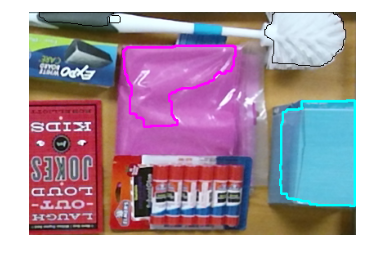

In [52]:
it_col = {'table_cloth':(255,0,255),'tissue_box':(0,255,255),'glue_sticks':(255,0,0),'toilet_brush':(255,255,0)}
#it_col = {'burts_bees_baby_wipes':(255,0,255),'bath_sponge':(0,255,255),'duct_tape':(255,0,0)}
image_disp = image_bin.copy()
mask_disp = mask_bin.copy()
for item in items:
    it_pos = [p for p,it in pos_ok if it==item]
    for cnt in it_pos:
        cv2.drawContours(image_disp,cnt,-1,it_col[item],2)
        cv2.drawContours(mask_disp,cnt,-1,(255,),-1)
for pos,w in pos_unkw:
    for cnt in pos:
        cv2.drawContours(image_disp,cnt,-1,(0,0,0),1)
        #cv2.drawContours(mask_disp,cnt,-1,(255,),-1)
plt.imshow(image_disp); plt.axis('off');

Lower bin items

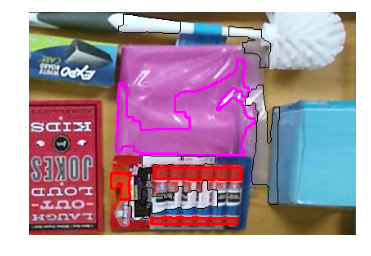

In [64]:
it_col = {'table_cloth':(255,0,255),'tissue_box':(0,255,255),'glue_sticks':(255,0,0),'toilet_brush':(255,255,0)}
#it_col = {'burts_bees_baby_wipes':(255,0,255),'bath_sponge':(0,255,255),'duct_tape':(255,0,0)}
image_disp = image_bin.copy()
mask_disp = mask_bin.copy()
for item in items:
    it_pos = [p for p,it in pos_ok if it==item]
    for cnt in it_pos:
        cv2.drawContours(image_disp,cnt,-1,it_col[item],2)
        cv2.drawContours(mask_disp,cnt,-1,(255,),-1)
for pos,w in pos_unkw:
    for cnt in pos:
        cv2.drawContours(image_disp,cnt,-1,(0,0,0),1)
        #cv2.drawContours(mask_disp,cnt,-1,(255,),-1)
plt.imshow(image_disp); plt.axis('off');

In [30]:
# For each known item: compute bounding box of all its contours -> dilate
# For each unknown contour:
# compute overlapping with each possible item
# if non overlapping -> remove item from candidates

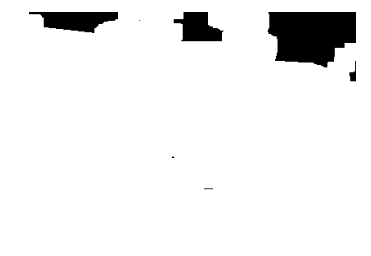

In [31]:
kernel = np.ones((3,3),np.uint8)
mask_disp = cv2.dilate(mask_disp,kernel,iterations = 5)
plt.imshow(mask_disp,cmap='gray'); plt.axis('off');

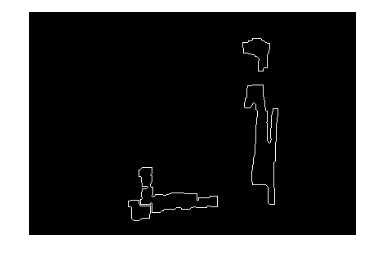

In [46]:
unkw_mask = np.zeros(mask_bin.shape,dtype='uint8')
for pos,w in pos_unkw:
    for cnt in pos:
        cv2.drawContours(unkw_mask,cnt,-1,(255,),-1)
#unkw_mask = cv2.bitwise_and(unkw_mask,unkw_mask,mask=255-mask_disp)
plt.imshow(unkw_mask,cmap='gray'); plt.axis('off');

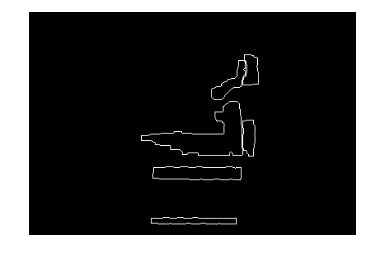

In [47]:
it_mask = np.zeros(mask_bin.shape,dtype='uint8')
for pos,it in pos_ok:
    for cnt in pos:
        cv2.drawContours(it_mask,cnt,-1,(255,),-1)
plt.imshow(it_mask,cmap='gray'); plt.axis('off');

[(0.096659176112086673, 'glue_sticks'), (0.13961579294096801, 'tissue_box'), (0.11201143079411489, 'toilet_brush'), (0.095917014235114686, 'table_cloth')]


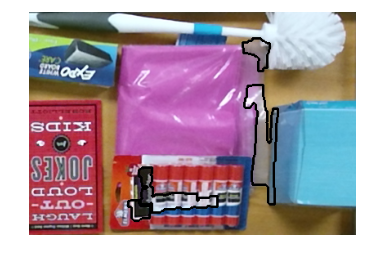

In [48]:
image_disp = image_bin.copy()
for pos,w in pos_unkw:
    print(w)
    for cnt in pos:
        cv2.drawContours(image_disp,cnt,-1,(0,0,0),2)
plt.imshow(image_disp); plt.axis('off');

In [130]:
# intersecting contours?

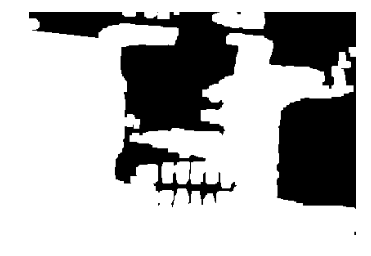

In [35]:
plt.imshow(mask_bin,cmap='gray'), plt.axis('off');

In [ ]:
# Draw filled contours in mask, dilate